In [7]:
import gym
import torch
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from typing import Tuple, Optional
from torch.distributions.categorical import Categorical

import numpy as np
import os
from loguru import logger
from torch.optim import Adam
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F
from pettingzoo.atari import combat_tank_v2
from pettingzoo.atari import space_war_v2
from pettingzoo.mpe import simple_v3
from itertools import count
from src.utils import (
    
    save_episode_as_gif,
    loss_fn_dqn
)
from src.agent import Agent
from src.agent_dqn import Agent_dqn
from src.policy import ValueFunctionQ
from src.buffer import ReplayBuffer

import numpy as np
from IPython.display import clear_output, display
from PIL import Image
from IPython.display import Image as IPImage
import io

plt.ion()
import warnings
warnings.filterwarnings("ignore")
torch.set_default_dtype(torch.float32)
SEED = 42

In [8]:

# instantiate the environment

env = space_war_v2.env(render_mode="rgb_array")
# env = combat_tank_v2.env(render_mode="rgb_array", has_maze=False)
env.reset(seed=SEED)

# get the state and action dimensions
observation = env.last()[0]  # Get initial observation
H, W, C = observation.shape # (height, width, channels)
action_dim = env.action_space("first_0").n

# num_actions = environment.action_space.n
# state_dimension = environment.observation_space.shape[0]
print(f"Input channels: {C}\nAction space: {action_dim}")

Input channels: 3
Action space: 18


## Model Definition

In [9]:


################################## Hyper-parameters Tuning ##################################
state_dimension: int = 16
num_actions: int = action_dim
EPOCHS: int = 1000
HIDDEN_DIMENSION: int = 16
LEARNING_RATE: float = 3e-3
DISCOUNT_FACTOR: float = .97
EPISODES: int = 3_000
gamma = DISCOUNT_FACTOR
BATCH_SIZE: int = 8

#############################################################################################

player_one = Agent_dqn('first_0_dqn', state_dimension, num_actions, HIDDEN_DIMENSION, LEARNING_RATE, BATCH_SIZE, obs_dim=(C, H, W), gamma=DISCOUNT_FACTOR)
player_two = Agent_dqn('second_0_dqn', state_dimension, num_actions, HIDDEN_DIMENSION, LEARNING_RATE, BATCH_SIZE, obs_dim=(C, H, W), gamma=DISCOUNT_FACTOR)

In [10]:
all_players = [player_one, player_two]
agents_map = dict(zip(env.agents, all_players))

agent_scores =  {k: 0 for k in env.agents}

for epoch in range(EPOCHS):
    # run one episode 
    env.reset()
    for step, agent_name in enumerate(env.agent_iter()):
        
        agent = agents_map[agent_name]
        try:
            win = agent.take_action(env)
        except:
            # env.reset()
            # winner = agent_name
            break
            #continue
        
        if win or step > 2*EPISODES:
            agent_scores[agent_name] += int(win)
            winner = agent_name
            break
    
    logger.info(f'Epoch: {epoch+1:4}/{EPOCHS} \t| Winner: {winner:10} \t| Steps: {step}')
    for player in all_players:
        loss, reward = player.optimize(loss_fn_dqn)
        logger.debug(f"Player: {player.name} \t| Cache Size: {len(player.cache)} \t| Loss: {loss*1e8:.5f} \t| Reward: {reward :.3f}")
        player.clear_cache()
        player.save()
    
    
    if (epoch+1) % 50 == 0:
        save_dir = "episodes_dqn"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_episode_as_gif(env, agents_map, save_path=f"{save_dir}/epoch_{epoch+1}.gif", fps=60)    

2024-12-05 14:10:03.375 | INFO     | __main__:<module>:25 - Epoch:    1/1000 	| Winner: second_0   	| Steps: 615
2024-12-05 14:10:03.405 | DEBUG    | __main__:<module>:28 - Player: first_0_dqn 	| Cache Size: 0 	| Loss: 4009689.01813 	| Reward: 0.000
2024-12-05 14:10:03.417 | DEBUG    | __main__:<module>:28 - Player: second_0_dqn 	| Cache Size: 0 	| Loss: 4811710.11925 	| Reward: 0.000
2024-12-05 14:10:03.763 | INFO     | __main__:<module>:25 - Epoch:    2/1000 	| Winner: second_0   	| Steps: 1313
2024-12-05 14:10:03.780 | DEBUG    | __main__:<module>:28 - Player: first_0_dqn 	| Cache Size: 0 	| Loss: 8037537.33635 	| Reward: 0.000
2024-12-05 14:10:03.806 | DEBUG    | __main__:<module>:28 - Player: second_0_dqn 	| Cache Size: 0 	| Loss: 2851624.04180 	| Reward: 0.000
2024-12-05 14:10:05.285 | INFO     | __main__:<module>:25 - Epoch:    3/1000 	| Winner: second_0   	| Steps: 5519
2024-12-05 14:10:05.295 | DEBUG    | __main__:<module>:28 - Player: first_0_dqn 	| Cache Size: 0 	| Loss: 378

KeyboardInterrupt: 

In [ ]:
agent_scores

{'first_0': 0, 'second_0': 2}

{'first_0': 42, 'second_0': 48}

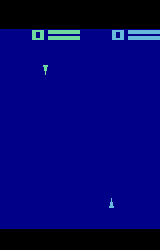

In [ ]:
gif_path = save_episode_as_gif(env, agents_map, fps=60)
IPImage(open(gif_path,'rb').read())